In [6]:
# This is required to run multiple processes on Unity for some reason.
from multiprocessing import set_start_method
try:
    set_start_method('spawn')
except: #Throws if already set
    pass

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax
from pathlib import Path
from importlib import reload

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)

import config, data, models, train, evaluate

In [77]:
reload(config)
from config import format_config

cfg = {
    # Data
    "data_dir": "../data/wqp",
    # "basin_file": "metadata/site_lists/sites_test.txt",  # relative to data_dir
    "basin_file": "metadata/site_lists/sites_turb_area1000_n10.txt",
    "features": {"daily": ["grfr_q"],
                 "irregular": ["Blue", "Green", "Red", "Nir", "Swir1", "Swir2"],
                 "static": None, # All are used when None
                 "target": "turbidity"},
    "time_slice": ["1979-01-01", "2018-12-31"], 
    "split_time": "2010-01-01",
    "sequence_length": 30,
    "log_norm_cols": ["turbidity","grfr_q"],
    "clip_target_to_zero": True,
    
    # DataLoader
    "shuffle": True,
    "batch_size": 16,
    "data_subset": "train",
    "num_workers": 2,
    "pin_memory": True,
    "drop_last": True,
    
    # Model
    "model": "eatransformer",
    "model_args": {"hidden_size": 64,
                   "intermediate_size": 64,
                   "num_layers": 2,
                   "num_heads": 2,
                   "dropout_p": 0.1,
                   "seed": 0}, 
    
    # Trainer
    "num_epochs": 100,
    "initial_lr": 0.001,
    "decay_rate": 0.01,
    "step_kwargs":{"loss": "mse",
                   "max_grad_norm": 2}, 
    
    # Outputs
    "quiet": False,  # Use to declutter the slurm output (removes tqdm)
    "log": False,
    "log_interval": 5
}
cfg = format_config(cfg)

In [8]:
# reload(data)
from data import TAPDataset

dataset = TAPDataset(cfg)

Dropping static attributes with 0 variance: ['glc_pc_s03', 'glc_pc_s05', 'glc_pc_s07', 'glc_pc_s08', 'glc_pc_s17', 'glc_pc_s19', 'pnv_pc_s03', 'wet_pc_s05', 'wet_pc_s06', 'wet_pc_s07']


Loading Basins:   0%|          | 0/556 [00:00<?, ?it/s]

Dataloader using 2 parallel CPU worker(s).
Batch sharding set to 1 cpu(s)


Epoch:001:   0%|          | 0/6694 [00:10<?, ?it/s]

Epoch:002:   0%|          | 0/6694 [00:00<?, ?it/s]

Epoch:003:   0%|          | 0/6694 [00:00<?, ?it/s]

vanishing gradients detected:
	.encoder.layers[0].attention_block.attention.query_proj.weight: 4
	.encoder.layers[0].attention_block.attention.key_proj.weight: 1


Epoch:004:   0%|          | 0/6694 [00:00<?, ?it/s]

Training finished or interrupted. Model state saved.


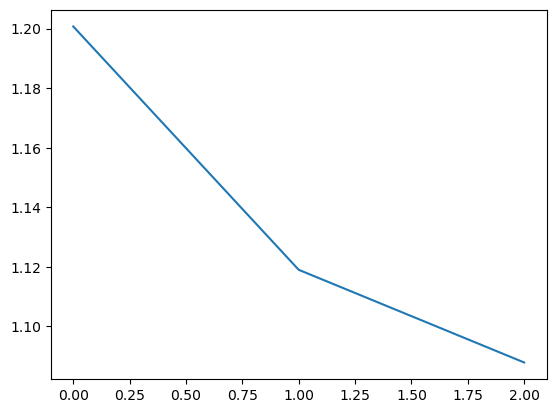

In [78]:
# reload(data)
from data import TAPDataLoader

reload(train)
from train import Trainer

# Specific to Transformer
cfg['model_args']['dynamic_in_size'] = len(dataset.daily_features) + len(dataset.irregular_features)
cfg['model_args']['static_in_size'] = len(dataset.static_features)
cfg['model_args']['max_length'] = cfg['sequence_length']

dataloader = TAPDataLoader(cfg, dataset)
trainer = Trainer(cfg, dataloader)
trainer.start_training()


In [46]:
trainer.opt_state[0].mu.encoder.embedder_block.daily_embedder.weight
trainer.opt_state[0]

ScaleByAdamState(count=Array(1673, dtype=int32), mu=EATransformer(
  encoder=Encoder(
    embedder_block=EmbedderBlock(
      daily_embedder=Linear(
        weight=f32[256,1],
        bias=f32[256],
        in_features=1,
        out_features=256,
        use_bias=True
      ),
      irregular_embedder=Linear(
        weight=f32[256,6],
        bias=f32[256],
        in_features=6,
        out_features=256,
        use_bias=True
      ),
      position_embedder=Embedding(
        num_embeddings=30,
        embedding_size=256,
        weight=f32[30,256]
      ),
      layernorm=LayerNorm(
        shape=(256,),
        eps=1e-05,
        use_weight=True,
        use_bias=True,
        weight=f32[256],
        bias=f32[256]
      ),
      dropout=Dropout(p=None, inference=None)
    ),
    layers=[
      TransformerLayer(
        attention_block=AttentionBlock(
          attention=MultiheadAttention(
            query_proj=Linear(
              weight=f32[256,256],
              bias=None,

In [ ]:
import optax

more_epochs = 150

trainer.load_state('epoch100')
loader_args['data_subset'] = 'train'
trainer.dataloader = TAPDataLoader(dataset, **loader_args)
trainer.lr_schedule = optax.exponential_decay(0.01, trainer.epoch+more_epochs, 0.001, transition_begin=trainer.epoch)
trainer.num_epochs += more_epochs
trainer.freeze_components('tealstm_i',True)
trainer.start_training() 

In [ ]:
lr_schedule = optax.exponential_decay(0.01, trainer.epoch+num_epochs, 0.001, transition_begin=trainer.epoch)
x = np.linspace(0,num_epochs*2)
y = lr_schedule(x)
plt.plot(x,y)

In [48]:
reload(evaluate)
from evaluate import predict, get_all_metrics

basin = np.random.choice(dataset.basins).tolist()

cfg['data_subset'] = 'test'
cfg['basin_subset'] =  basin
cfg['num_workers'] = 0 # Faster for small runs
dataloader = TAPDataLoader(cfg, dataset)

results = predict(trainer.model, dataloader, seed=0, denormalize=True)
results['pred'] = results['pred'] * (results['pred']>0) #Clip predictions to 0
metrics = get_all_metrics(results['obs'],results['pred'])
metrics

Dataloader using 0 parallel CPU worker(s).
Batch sharding set to 1 cpu(s)


  0%|          | 0/51 [00:00<?, ?it/s]

{'mae': 57.189526,
 'mse': 18685.596,
 'rmse': 136.69527,
 'kge': -0.4343486242121104,
 'nse': -226.3272247314453}

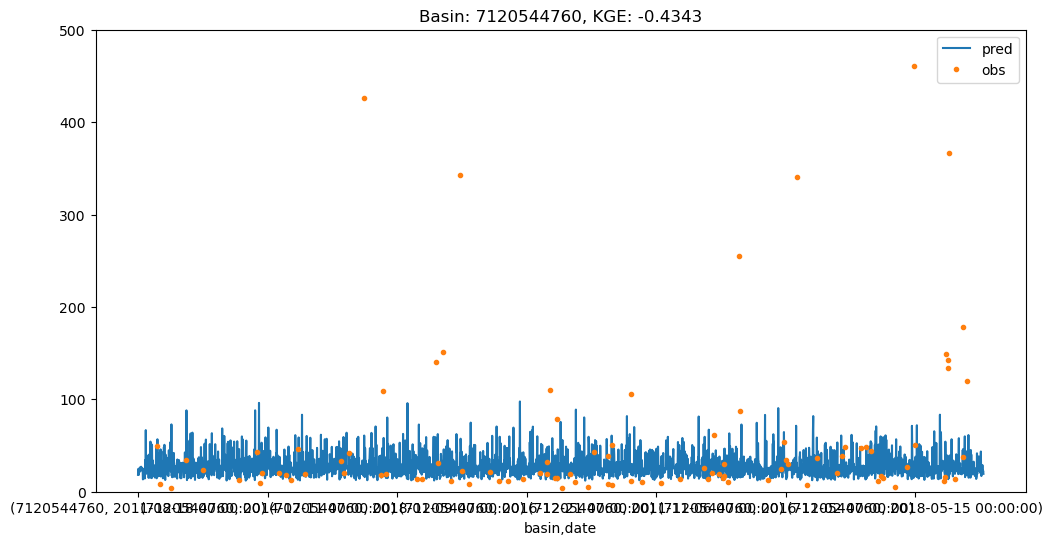

In [49]:
# Plot the true values and predictions
fig, ax = plt.subplots(figsize=(12, 6))
results['pred'].plot(ax=ax)
results['obs'].plot(ax=ax,linestyle='None',marker='.')

metrics = get_all_metrics(results['obs'],results['pred'])

plt.title(f"Basin: {basin}, KGE: {metrics['kge']:0.4f}")
plt.legend()
plt.ylim([0,500])
plt.show()

In [ ]:
results.plot.scatter('obs','pred')
plt.gca().axis('square')
plt.xlim([0,20])
plt.ylim([0,20])
plt.show()

In [ ]:
from train import make_step
from tqdm.notebook import trange

# See if we can recreate the error... 
data = trainer.load_state("exceptions/epoch130_exception0")
for i in trange(1000):
    make_step(trainer.model, data['batch'], trainer.opt_state, trainer.optim,
              trainer.filter_spec, loss_name="mse", max_grad_norm=None, l2_weight=None)